# FAOLEX Database<br><br>

The UN's Food and Agricultural Organization (FAO) has some amazing databases. While land use researchers are familiar with their flagship [FAOSTAT](http://www.fao.org/faostat/en/), there is an amazing legal database that can help ground global studies. Today, I wanted to highlight the [FAOLEX legal and policy database](http://www.fao.org/faolex/en/).

Most of my research has been about smallholder farmers, so I explored this data to look at land consolidation, land subdivision, and smallholder farmer policies. Here's an overview of whats in FAOLEX. (Here's a recent [blog post](https://medium.com/the-nature-of-food/small-farms-grow-a-large-portion-of-the-worlds-food-59ed07019a9) on smallholders if you want to learn more).

## Motivation<br><br>

First things first, let me explain some motivation for looking at land consolidation policies. Farms are getting really large in high income countries and really small in low income countries (here's a [great paper](https://www.sciencedirect.com/science/article/pii/S0305750X15002703) on it). I wanted to look at policies that might be making farms to get big and small.

### Global Transition in Farm Size<br><br>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import warnings
from matplotlib import cm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
# import weighted
import seaborn as sns
import scipy.stats as stats
import pylab
from graphviz import Digraph
import os
import jenkspy
from IPython.display import Image
import networkx as nx
import matplotlib.gridspec as gridspec
# from colormap import rgb2hex
import matplotlib.patches as mpatches

%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

In [4]:
df_farmsize = pd.read_csv('../data/Lowder_Supp_farmsize_time.csv')
df_farmsize['Income_Class'] = df_farmsize['Income_Class'].str.strip()

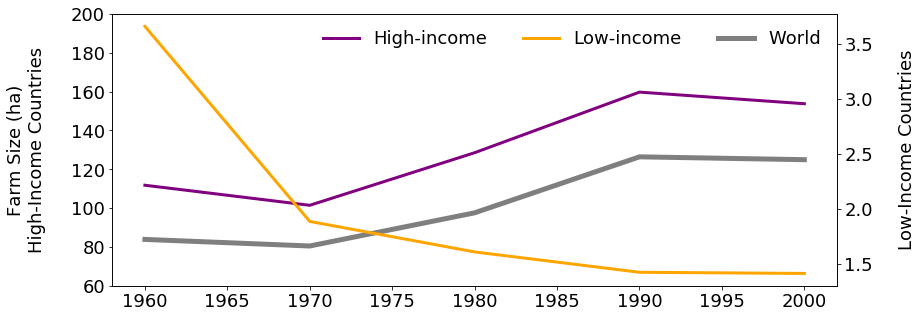

In [5]:
df_farmsize_hs = df_farmsize.loc[
    (df_farmsize['Income_Class'] == 'High-income') |
    (df_farmsize['Income_Class'] == 'Low-income')
]

melted = pd.melt(
    df_farmsize_hs, 
    id_vars=['Income_Class', 'Country'],
    value_vars=['1960', '1970', '1980', '1990', '2000']
)

piv = pd.pivot_table(
    melted,
    index=['Income_Class', 'variable'],
    values='value',
    aggfunc=np.mean
).reset_index()

piv['variable'] = piv['variable'].astype(int)

# Plot
fig = plt.figure(figsize=[13, 5])
ax = fig.add_subplot(111)

for num, i in enumerate(df_farmsize_hs['Income_Class'].unique()):
    
    tmp = piv.loc[piv['Income_Class'] == i]
    
    if 'Low' in i:
        ax2 = ax.twinx()
        ax2.plot(tmp['variable'], tmp['value'], '-', label=i, color='orange', linewidth=3)
        ax.plot(tmp['variable'], tmp['value'], '-', label=i, color='orange', linewidth=3)
        
    else:
        ax.plot(tmp['variable'], tmp['value'], '-', label=i, color='purple', linewidth=3)

piv = pd.pivot_table(
    melted,
    index=['variable'],
    values='value',
    aggfunc=np.mean
).reset_index()

piv['variable'] = piv['variable'].astype(int)
ax.plot(piv['variable'], piv['value'], '-', label='World', color='k', linewidth=5, alpha=0.5)

ax.legend(loc='upper right', frameon=False, fontsize=18, ncol=3)
ax.set_ylim([60, 200])
ax2.set_ylabel('\nLow-Income Countries', fontsize=18)
ax.set_ylabel('Farm Size (ha)\nHigh-Income Countries\n', fontsize=18)

for x in [ax, ax2]:
    x.tick_params(labelsize=18)

plt.show()

## Quick Analysis<br><br>

### Land Reform Policies<br><br>

Here are the FAOLEX coded 'smallholder' policies (top) and 'land reform' policies (bottom). There have been many more smallholder policies entered into their database in more recent years, which makes sense because there has been [growing concern about smallholder farmers](https://www.annualreviews.org/doi/full/10.1146/annurev-environ-102016-060946).

In [6]:
def plt_policies(main_data, data, title='None', ax=None):

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world[(world.name!="Antarctica")]
    world = world.to_crs("+proj=robin")    
    world = pd.merge(world, data, left_on='name', right_on='Value', how='outer')
    nodata = world.loc[world['Count'].isnull()]
    isdata = world.loc[world['Count'].notnull()]

    nodata.plot(column='Count', 
                ax=ax, 
                color='k', 
                alpha=0.1)
        
    cax = isdata.plot(column='Count', 
                ax=ax, 
                cmap='Blues', 
#                 vmin=isdata['Count'].min(),
#                 vmax=isdata['Count'].max(),
                alpha=1., 
                edgecolor='k', 
                linewidth=.3,
                scheme='quantiles')

    ax.grid(alpha=0.0)

    plt.tick_params(
        axis='both',          
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off') 

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_title(title, fontsize=18)
    
    ax.set_aspect('equal')
        
    return ax

    
def colorbar_cax(fig, axes=[None], ticks=[None], ticklabels=[None]):
    """
    Plots color bar
    params:
        fig
    return:
        cbar object
    """
    
    cax = fig.add_axes(axes)
    vmin, vmax = -1, 1
    sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []  # fake up the array of the scalar mappable.
    cbar = fig.colorbar(sm, cax=cax)

    return cbar

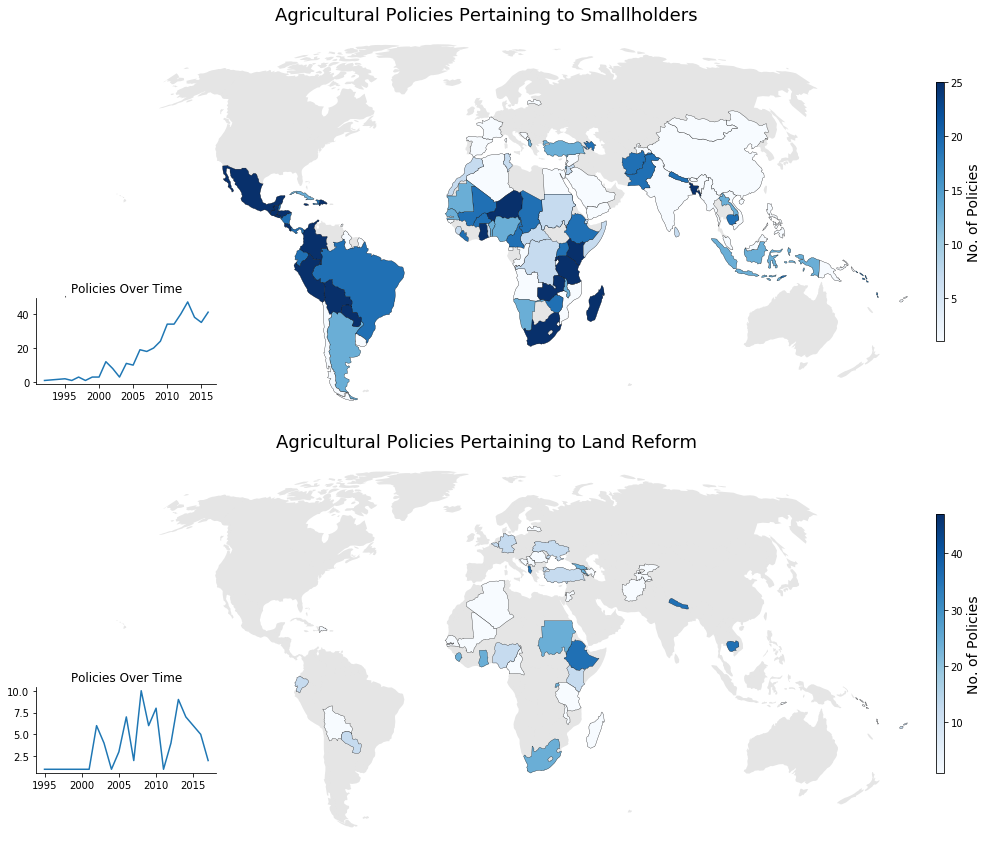

In [23]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
world = world.to_crs("+proj=robin")

df_landleg = pd.read_csv('../data/FAOLEX_landpolicies.csv')
df_landleg['Value'] = df_landleg['Value'].str.strip()

dictionary = {
    'Bosnia and Herzegovina': 'Bosnia and Herz.',
    'Central African Republic': 'Central African Rep.',
    'Congo - Dem. Rep. of': 'Dem. Rep. Congo',
    "C\xc3\xb4te d'Ivoire": "C\xf4te d'Ivoire",
    'Dominican Republic': 'Dominican Rep.',
    'Equatorial Guinea': 'Eq. Guinea',
    "Lao - People's Dem. Rep": 'Lao PDR',
    'Palestinian Authority': 'Palestine',
    'Solomon Islands': 'Solomon Is.',
    'South Sudan': 'Sudan',
    'Syrian Arab Republic': 'Syria',
    'Tanzania - Un. Rep. of': 'Tanzania',
    'United States of America': 'United States',
    'Viet Nam': 'Vietnam'
}

df_landleg['new'] = df_landleg['Value'].map(dictionary)
df_landleg['Value'] = np.where(df_landleg['new'].notnull(), 
                               df_landleg['new'], 
                               df_landleg['Value'])
df_landleg = df_landleg.drop('new', axis=1)

land_cons = df_landleg.loc[(df_landleg['Type'] == 'Land Consolidation') & 
                           (df_landleg['Variable'] == 'Country')]
land_reform = df_landleg.loc[(df_landleg['Type'] == 'Land Reform') |
                             (df_landleg['Type'] == 'Land Consolidation') & 
                             (df_landleg['Variable'] == 'Country')]

land_reform = pd.pivot_table(land_reform, 
                             index='Value', 
                             values='Count', 
                             aggfunc=np.sum).reset_index()

land_small = df_landleg.loc[(df_landleg['Type'] == 'Smallholders') & 
                            (df_landleg['Variable'] == 'Country')]

# Calculate n per legislation type
# piv = df_landleg.pivot_table(index=['Type', 'Variable'], 
#                              values='Count', 
#                              aggfunc=lambda x: len(np.unique(x))).reset_index()
# land_cons_n = piv.loc[piv['Type'] == 'Land consolidation'].reset_index()['Count'][0]
# land_subd_n = piv.loc[piv['Type'] == 'Land Reform'].reset_index()['Count'][0]
# land_small_n = piv.loc[piv['Type'] == 'Smallholders'].reset_index()['Count'][0]
# print piv


# This should be refactored if end up using
fig = plt.figure(figsize=[25, 12])

# Plot Smallholder legislation
ax = fig.add_subplot(211)
plt_policies(df_landleg, land_small, title='Agricultural Policies Pertaining to Smallholders', ax=ax)

# # Add colorbar
cax = fig.add_axes([0.75, 0.6, 0.004, 0.3])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=land_small['Count'].min(), 
                                                              vmax=land_small['Count'].max()))
sm._A = []  # fake up the array of the scalar mappable.
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('No. of Policies', fontsize=14)


# Add time plot
cax = fig.add_axes([0.25, 0.55, 0.1, 0.1])

land_small = df_landleg.loc[(df_landleg['Type'] == 'Smallholders') & 
                            (df_landleg['Variable'] == 'Year') &
                            (df_landleg['Value'] != '2017')]

cax.plot(land_small['Value'], land_small['Count'], '-')
cax.set_title('Policies Over Time')
# Turn off top and right spines
cax.spines['right'].set_visible(False)
cax.spines['top'].set_visible(False)



# Plot land consolidation legislation
ax = fig.add_subplot(212)
plt_policies(df_landleg, land_reform, title='Agricultural Policies Pertaining to Land Reform', ax=ax)

# Add colorbar
cax = fig.add_axes([0.75, 0.1, 0.004, 0.3])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=land_small['Count'].min(), 
                                                              vmax=land_small['Count'].max()))
sm._A = []  # fake up the array of the scalar mappable.
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('No. of Policies', fontsize=14)


# Add time plot
cax = fig.add_axes([0.25, 0.1, 0.1, 0.1])

land_cons = df_landleg.loc[(df_landleg['Type'] == 'Land Reform') |
                            (df_landleg['Type'] == 'Land Consolidation') & 
                            (df_landleg['Variable'] == 'Year') &
                            (df_landleg['Value'] != '2017')]

land_cons = land_cons.loc[land_cons['Variable'] == 'Year']
land_cons = pd.pivot_table(land_cons, index='Value', values='Count', aggfunc=np.sum).reset_index()

cax.plot(land_cons['Value'], land_cons['Count'], '-')
cax.set_title('Policies Over Time')
# Turn off top and right spines
cax.spines['right'].set_visible(False)
cax.spines['top'].set_visible(False)


fig.tight_layout()
plt.show()

### Land Consolidation<br><br>

I looked at the land consolidation policies in detail because they directly affect the size of farms.

Here are a couple of highlights from the database. I went through the 25 land consolidation documents and found countries with pro-large farm policies, initiatives that supported having more small farm, and a mixed system that supports both farm types.

Pro consolidation
1. [Albania's land consolidation stance: "assisting farmers to improve farm structures by reducing land fragmentation and enlarging farm sizes"](http://www.fao.org/faolex/results/details/en/c/LEX-FAOC149677/) [link2](http://www.fao.org/faolex/results/details/en/c/LEX-FAOC149566/)
2. [Armenia policies for land consolidation for ag economic growth](http://www.fao.org/faolex/results/details/en/c/LEX-FAOC149507/)
3. [China's most recent land consolidation policy moves - detailed in later sections](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1465-7287.2010.00236.x)
4. [Jordan "encouraging the conservation and reduction of fragmentation of agricultural land"](http://www.fao.org/faolex/results/details/en/c/LEX-FAOC166604/)
5. [Turkey's land consolidation stance: "The effectiveness of agricultural businesses will be increased on the basis of business size with sufficient level of income according to the production type, considering the social structure of the sector. Land fragmentation will be prevented and a well-functioning agricultural land market will be developed."](http://www.fao.org/faolex/results/details/en/c/LEX-FAOC175696/)

Mixed focus on consolidation and smallhodler support
1. [Georgia's small and medium strategy combined with consolidation](http://www.fao.org/faolex/results/details/en/c/LEX-FAOC145265/)
2. [Ghana's dual focus on supporting small-holders and settin aside land banks for largeholders and initiating adjacent 'block farms'](http://www.fao.org/faolex/results/details/en/c/LEX-FAOC174498/) [link2](http://www.fao.org/faolex/results/details/en/c/LEX-FAOC149618/)
3. [Nepal: "a farming sector composed of adequately sized farms that use land efficiently and sustainably"](http://www.fao.org/faolex/results/details/en/c/LEX-FAOC171433/)

Small farm support
1. [Cambodia's commitment to smallholders, although hard to really trust because of the vast recent history of land grabs facilitated by the government and publically opposed by smallholders](http://www.fao.org/faolex/results/details/en/c/LEX-FAOC173300/)
2. [Latvia's promotion of smaller farms to conserve ag landscapes and conservation](http://www.fao.org/faolex/results/details/en/c/LEX-FAOC174235/)
3. [South Africa's more equitable and pro-small strategy](http://www.fao.org/faolex/results/details/en/c/LEX-FAOC174824/)


Unclassified
1. [EU's CAP with rhetoric towards supporting small but in reality suporting larger farms; need decent reference here about CAP subsidy payments being linked to farm size and CAP policies have resulted in lag land consolidation and fewer farmers](http://ec.europa.eu/eurostat/statistics-explained/index.php/Small_and_large_farms_in_the_EU_-_statistics_from_the_farm_structure_survey)

#### Cross-coded Legislation for Land Consolidation and Subdivisions of Land 1990-2017<br><br>

I then wanted to see why policies wanted to support larger or smaller farms. Each entry in FAOLEX is cross coded with many other variables, including an agriculture and rural economic development variable and environmental variables. If we look at what land consolidation is cross coded with, we start to understand what types of motivations policy makers have when having 'go big' policies.

It turns out, ~20% of the land consolidation documents were cross coded with agriculture and rural economic development, while ~20% of the documents pertaining to subdivision of land were cross coded with environmental variables (i.e., air & atmosphere, environment general, waste & hazardous substances, water, and wild species & ecosystems). 

The relationship in the policy documents between the reasoning for consolidation or subdivision is not always along the lines of protection of natural resources or economic development. There were many examples of countries wanting to consolidate agricultural land for profit and to increase resource efficiency, there were also a lot of these documents legislatively defining how to go about consolidation or subdivisions; indicating a need for refined legislation not a poicy objective.

In [24]:
dyads = df_landleg.loc[df_landleg['Variable'] == 'Dyad']
dyads['ranked'] = dyads.groupby('Type')['Count'].rank(ascending=False)
dyads = dyads.loc[(dyads['ranked'] < 12.) & (dyads['ranked'] > 1) ]
dyads['Value'] = dyads['Value'].str.title()
dyads = dyads.sort_values(['Type', 'ranked'])

In [25]:
s = dyads.loc[dyads['Type'] == 'Smallholders']
ns = dyads.loc[dyads['Type'] != 'Smallholders']
dyads = pd.concat([s, ns])

In [26]:
l = dyads['Value'].unique()[::-1]
x = [0.5 for i, j in enumerate(l)]
y = [float(i) / len(l) for i, j in enumerate(l)]
pos_fix = dict(zip(l, zip(x, y)))

pos = {
    'Land Consolidation': (0., 0.),
    'Land Reform': (0, 0.5),
    'Smallholders': (0, 1)
}
pos.update(pos_fix)

In [27]:
dyads['tmp_Count'] = np.where(
    dyads['Type'] == 'Smallholders', 
    dyads['Count'],
    dyads['Count'].min()
)
tmp = dyads.drop_duplicates(['Value'])
node_size = dict(zip(tmp['Value'], tmp['tmp_Count']))

node_size_tmp = {
    'Land Consolidation': tmp['Count'].max() + 200,
    'Land Reform': tmp['Count'].max() + 200,
    'Smallholders': tmp['Count'].max() + 200
}

node_size.update(node_size_tmp)

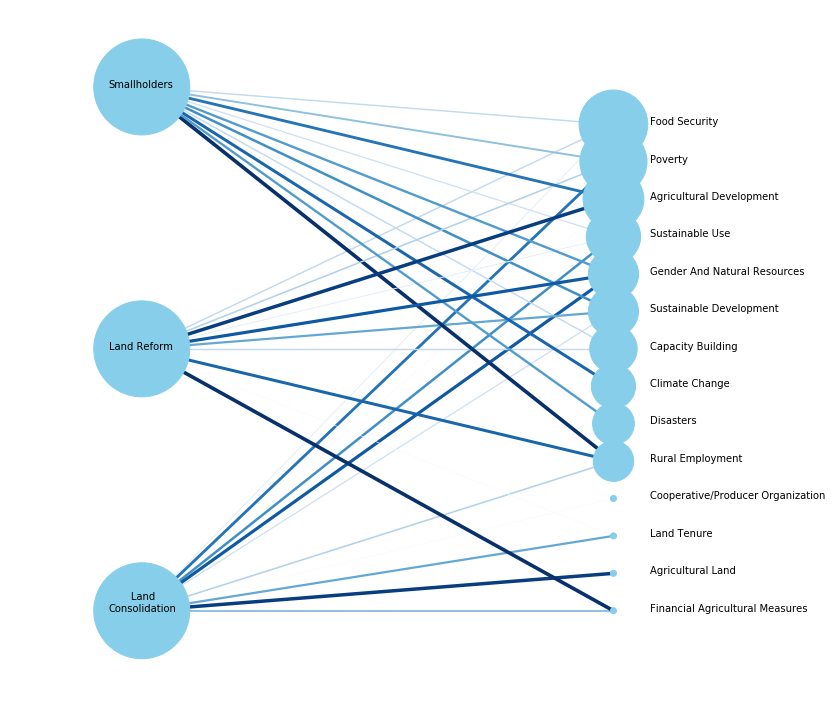

In [30]:
fig = plt.figure(figsize=[10, 10])

tmp = dyads.copy()

G = nx.from_pandas_edgelist(
    tmp, 'Type', 'Value',
    create_using=nx.Graph()
)

d = nx.degree(G)

ax = fig.add_subplot(111)

nx.draw(
    G, 
    #labels=dict(zip(pos.keys(), pos.keys())),
    node_color='skyblue', 
#     node_size=[v**2 * 100 for v in d.values()], 
    node_size=[v**1.45 for v in node_size.values()],
    edge_color=tmp['ranked'], 
    width=tmp['ranked']*10**-0.5,
    edge_cmap=plt.cm.Blues,
    pos=pos,
    ax=ax
)

for k, v in pos.items():

    if k in ['Smallholders', 'Land Reform', 'Land Consolidation']:
        x = v[0] - 0.035
        k = k.replace('Land C', '       Land C')
        k = k.replace(' C', '\nC')
    else:
        x = v[0] + 0.039   
        
    ax.text(x, v[1], s=k)

fig.tight_layout()
plt.show()



### Data Note<br><br>

- [FAOLEX's](http://www.fao.org/faolex/en/) advanced search was used to find the 25 policy documents.
- The following search criteria was set:
    - Policies tagged as 'Land Consolidation'
    - Agricultural and rural development
    - Livestock
    - Cultivated plants
    - Food and nutrition
    - Fisheries and aquaculture
    - Land & soil
    - Environment
    - Water
- Of the 25 results, there were 20 countries represented
- 18 of the documents had English versions
- 11 Countries were identified to explicitly discuss land consolidation. China was added to the list because we found reference to it policies in the systematic review serach process. (and EU's CAP is discussed bt=ut not included in the numbers)
- 5 countries were coded as promoting land consolidation; 3 promoted smaller farms; and 3 had mixed promotion of small and large farms

## Take Aways<br><br>

FAOLEX is a really interesting resource that can be used to help ground land use science research. But in looking at the dataset, I have a few words of caution. The list of policy documents is not exhaustive. Some countries have a lot more documents than others. When conducting a trend analysis, I suggest figuring out a way to weight the number of documents by the number in particular countries. Also, there is no way to understand if a legislation was approved, over-turned, or changed. This makes an actual legislative analysis difficult. Instead, it might be more useful to look at the sentiment of the policy documents to get a sense of how countries are viewing different actors and to understand their development focus.

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

In [3]:
HTML('''
<style>
    .yourDiv {position: fixed;top: 100px; right: 0px; 
              background: white;
              height: 5%;
              width: 175px; 
              padding: 10px; 
              z-index: 10000}
</style>
<script>
function showthis(url) {
	window.open(url, "pres", 
                "toolbar=yes,scrollbars=yes,resizable=yes,top=10,left=400,width=500,height=500");
	return(false);
}
</script>

<div class=yourDiv id=media-mobile>
    <a href="javascript:code_toggle()">Toggle Code On/Off</a><br>
</div>
''')